In [38]:
# Packages
import pandas as pd
import numpy as np
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics         import make_scorer
from sklearn.base            import clone
from xgboost                 import XGBRegressor
import joblib, mlflow
import mlflow.sklearn
import optuna
import warnings
from optuna.integration import OptunaSearchCV, MLflowCallback
from optuna.distributions import FloatDistribution, IntDistribution
from catboost import CatBoostRegressor, Pool

# Custom Metric for Training Feedback
def rmsle_xgb(preds, dtrain):
    y_true = dtrain.get_label()
    preds = np.maximum(preds, 0)
    rmsle = np.sqrt(np.mean((np.log1p(preds) - np.log1p(y_true)) ** 2))
    return 'rmsle', rmsle

# Custom Metric for GridSearch (wrapped in make_scorer)
def rmsle_sklearn(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle_sklearn, greater_is_better=False)
# Data
df = pd.read_csv('playground-series-s5e5/train.csv')
y = df['Calories']
X = df.drop(columns=(['Calories', 'id']))

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=X['Sex']
)

# Custom Feature Engineering
def add_bmi_intensity(X_df: pd.DataFrame) -> pd.DataFrame:
    """Adds BMI and HeartRatexDuration features"""
    X = X_df.copy()
    X['BMI'] = (X['Weight'] / (X['Height'] / 100) ** 2).round(2)
    X['Timed_Intensity'] = X['Duration'] * X['Heart_Rate']
    X['Heart_Rate_Zone'] = (
        X['Heart_Rate'] / (220 - X['Age'])
    ) * 100
    X['Mifflin_Jeor_BMR'] = np.where(
        X['Sex'] == 'male',
        (10 * X['Weight']) + (6.25 * X['Height']) - (5 * X['Age']) + 5,
        (10 * X['Weight']) + (6.25 * X['Height']) - (5 * X['Age']) - 161,
    )
    return X

feat_eng = FunctionTransformer(add_bmi_intensity, validate=False)
# ──────────────────────────────────────────────────────────────────────
# MODEL & PIPELINE
# ──────────────────────────────────────────────────────────────────────
cat_model = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=42,
        verbose=False,
        cat_features=["Sex"]
)

pipe = Pipeline([
    ("feat_eng", feat_eng),
    ("model", cat_model)
])
# ──────────────────────────────────────────────────────────────────────
# GRID  (prefix params with model__)
# ──────────────────────────────────────────────────────────────────────
def cat_objective(trial):
    params = {
        "model__depth":               trial.suggest_int("model__depth", 5, 10),
        "model__iterations":          trial.suggest_int("model__iterations", 600, 1600),
        "model__learning_rate":       trial.suggest_float("model__learning_rate", 0.01, 0.2, log=True),
        "model__l2_leaf_reg":         trial.suggest_float("model__l2_leaf_reg", 1, 10, log=True),
        "model__bagging_temperature": trial.suggest_float("model__bagging_temperature", 0, 1),
    }

    score = cross_val_score(
                clone(pipe).set_params(**params),
                X_train, y_train,
                scoring=rmsle_scorer,
                cv=5,
                n_jobs=-1
            ).mean()
    return score

In [ ]:
# ------------------------------------------------------------------
# MLFLOW + OPTUNA LOOP  (same structure)
# ------------------------------------------------------------------
mlflow.set_tracking_uri("http://127.0.0.1:5000")


mlflow.set_experiment("Calories-CB-Optuna-V3")
mlflow.sklearn.autolog(log_models=False)

study_cb = optuna.create_study(direction="maximize", study_name="cat_rmsle_1")

with mlflow.start_run(run_name="optuna_parent_cb"):
    mlflow_cb = MLflowCallback(
        tracking_uri=mlflow.get_tracking_uri(),
        metric_name="neg_rmsle_cv",
        mlflow_kwargs={"nested": True}
    )

    study_cb.optimize(cat_objective, n_trials=50, callbacks=[mlflow_cb], show_progress_bar=True)

    mlflow.log_params(study_cb.best_trial.params)
    mlflow.log_metric("best_neg_rmsle_cv", study_cb.best_value)

In [40]:
# ------------------------------------------------------------------
# Best hyper-parameters returned by Optuna
# ------------------------------------------------------------------
best_params = {
    "model__depth":               10,
    "model__iterations":          1594,
    "model__learning_rate":       0.08318728723922084,
    "model__l2_leaf_reg":         3.7912206788501206,
    "model__bagging_temperature": 0.3000645110427449,
}

# ------------------------------------------------------------------
# Rebuild the final pipeline
# (reuse the same feat_eng transformer defined earlier)
# ------------------------------------------------------------------

cat_final = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=42,
        verbose=False,
        cat_features=["Sex"]
)

final_pipe = Pipeline([
        ("feat_eng", feat_eng),
        ("model",    cat_final)
]).set_params(**best_params)

# ------------------------------------------------------------------
# Fit on the full dataset (train + val)
# ------------------------------------------------------------------
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

final_pipe.fit(X_full, y_full)

# ------------------------------------------------------------------
# Save / log the artefact
# ------------------------------------------------------------------
joblib.dump(final_pipe, "calories_catboost_optuna.joblib")

# Log to MLflow
with mlflow.start_run(run_name="catboost_final_fit"):
    mlflow.log_params(best_params)
    mlflow.sklearn.log_model(final_pipe, artifact_path="model")


2025/05/25 14:26:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d61280d7abb48dc86b7de3a3f248c59', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/25 14:59:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) 

In [41]:
# LOADING XGBOOST FINAL FROM MLFLOW  ──────────────────────────────────────────────
exp = mlflow.get_experiment_by_name("xgb_rmsle_1")

runs = mlflow.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string='tags.mlflow.runName = "final_rmsle_model_optuna"',
        order_by=["start_time DESC"],
        max_results=1,
)
final_run_id = runs.iloc[0].run_id
print("Run found:", final_run_id)
xgb_final = mlflow.sklearn.load_model(f"runs:/{final_run_id}/model")

Run found: bfdc77e266614b8d9d642cc56e14816b


In [21]:

''' 
# Custom Metric for Training Feedback
def rmsle_xgb(preds, dtrain):
    y_true = dtrain.get_label()
    preds = np.maximum(preds, 0)
    rmsle = np.sqrt(np.mean((np.log1p(preds) - np.log1p(y_true)) ** 2))
    return 'rmsle', rmsle

# Custom Metric for GridSearch (wrapped in make_scorer)
def rmsle_sklearn(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

rmsle_scorer = make_scorer(rmsle_sklearn, greater_is_better=False)

# Data
df = pd.read_csv('playground-series-s5e5/train.csv')
y = df['Calories']
X = df.drop(columns=(['Calories', 'id']))

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=X['Sex']
)

# Custom Feature Engineering
def add_bmi_intensity(X_df: pd.DataFrame) -> pd.DataFrame:
    """Adds BMI and HeartRatexDuration features"""
    X = X_df.copy()
    X['BMI'] = (X['Weight'] / (X['Height'] / 100) ** 2).round(2)
    X['Timed_Intensity'] = X['Duration'] * X['Heart_Rate']
    return X

feat_eng = FunctionTransformer(add_bmi_intensity, validate=False)

# Preprocessor
cat_col = ['Sex']
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_col)
    ],
    remainder='passthrough'
)

# ──────────────────────────────────────────────────────────────────────
# MODEL & PIPELINE
# ──────────────────────────────────────────────────────────────────────
xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
)

xgb_pipe = Pipeline(steps=[
        ("feat_eng",   feat_eng),
        ("preprocess", preprocess),
        ("model",      xgb)
])

best_params = {
    "model__max_depth": 9,
    "model__learning_rate": 0.023658702935574594,
    "model__n_estimators": 1373,
    "model__subsample": 0.9815205434675509,
    "model__colsample_bytree": 0.8460760959011027,
    "model__reg_alpha": 0.4849891315002537,
    "model__reg_lambda": 1.6645566204520426,
    "model__min_child_weight": 0.37163348840668015
    }

# fresh clone to avoid any state leakage from grid-search
best_xgb_pipe = clone(xgb_pipe).set_params(
        **best_params
)
'''

' \n# Custom Metric for Training Feedback\ndef rmsle_xgb(preds, dtrain):\n    y_true = dtrain.get_label()\n    preds = np.maximum(preds, 0)\n    rmsle = np.sqrt(np.mean((np.log1p(preds) - np.log1p(y_true)) ** 2))\n    return \'rmsle\', rmsle\n\n# Custom Metric for GridSearch (wrapped in make_scorer)\ndef rmsle_sklearn(y_true, y_pred):\n    y_pred = np.maximum(y_pred, 0)\n    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))\n\nrmsle_scorer = make_scorer(rmsle_sklearn, greater_is_better=False)\n\n# Data\ndf = pd.read_csv(\'playground-series-s5e5/train.csv\')\ny = df[\'Calories\']\nX = df.drop(columns=([\'Calories\', \'id\']))\n\nX_train, X_val, y_train, y_val = train_test_split(\n    X, y,\n    test_size=0.2,\n    random_state=42,\n    stratify=X[\'Sex\']\n)\n\n# Custom Feature Engineering\ndef add_bmi_intensity(X_df: pd.DataFrame) -> pd.DataFrame:\n    """Adds BMI and HeartRatexDuration features"""\n    X = X_df.copy()\n    X[\'BMI\'] = (X[\'Weight\'] / (X[\'Height\']

In [42]:
# ------------------------------------------------------------------
# 1. temporary clones, TRAIN-only fit
# ------------------------------------------------------------------
xgb_trn = clone(xgb_final).fit(X_train, y_train)
cat_trn = clone(final_pipe).fit(X_train, y_train)

xgb_val = xgb_trn.predict(X_val)
cat_val = cat_trn.predict(X_val)

from scipy.optimize import minimize_scalar
w_opt = minimize_scalar(
           lambda w: rmsle_sklearn(y_val, w*xgb_val + (1-w)*cat_val),
           bounds=(0, 1), method="bounded"
       ).x

print(f"Optimal blend weight (train-only models): {w_opt:.3f}")

2025/05/25 15:03:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5d7e909476114628a3bd6390900eaf8e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/05/25 15:29:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) 

Optimal blend weight (train-only models): 0.656


In [43]:
# ──────────────────────────────────────────────────────────────────────
# TEST SET RUN
# ──────────────────────────────────────────────────────────────────────

df_test_cat = pd.read_csv("playground-series-s5e5/test.csv")
ids_cat = df_test_cat["id"]

X_test_cat = df_test_cat.drop(columns=["id"])
test_preds_cat = final_pipe.predict(X_test_cat)

df_test_xgb = pd.read_csv("playground-series-s5e5/test.csv")
ids_xgb = df_test_xgb["id"]

X_test_xgb = df_test_xgb.drop(columns=["id"])
test_preds_xgb = xgb_final.predict(X_test_xgb)

final_pred = w_opt * test_preds_xgb + (1 - w_opt) * test_preds_cat
final_pred = np.maximum(final_pred, 0)

submission = pd.DataFrame({
    "id": ids_cat,
    "Calories": final_pred
})

import os
if os.path.isfile("submission_5.csv"):
    pass
else:
    submission.to_csv("submission_5.csv", index=False)

2025/05/25 16:23:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\afise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/25 16:34:24 WARNING mlflow.utils.autologging_utils: ML

In [44]:
# ──────────────────────────────────────────────────────────────────────
# POST TRAINING EDA
# ──────────────────────────────────────────────────────────────────────
xgb_est = xgb_final.named_steps["model"]
cb_est = final_pipe.named_steps["model"]

X_sample = feat_eng.transform(X_full.head(1))           
ct = xgb_final.named_steps["preprocess"]          
feat_names = ct.get_feature_names_out(X_sample.columns)
feat_names_cb = cb_est.feature_names_

<Axes: >

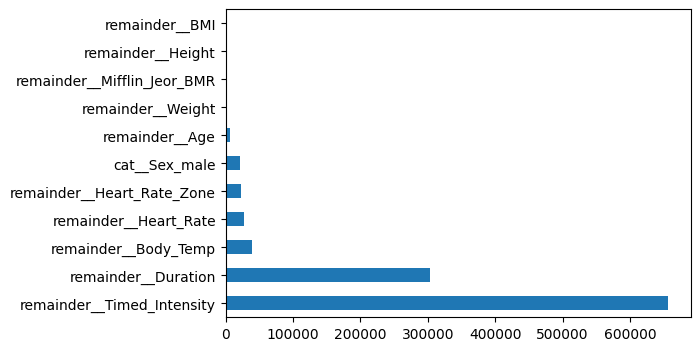

In [45]:
# ──────────────────────────────────────────────────────────────────────
# Classic gain / split importance
# ──────────────────────────────────────────────────────────────────────

# XGBoost
feat_names = ct.get_feature_names_out(feat_eng.transform(X_full.head(1)).columns)
fname_map = {f"f{idx}": name for idx, name in enumerate(feat_names)}
raw_gain = xgb_est.get_booster().get_score(importance_type="gain")
gain_named = {fname_map[k]: v for k, v in raw_gain.items()}

fi_xgb = (pd.Series(gain_named)
            .sort_values(ascending=False)
            .head(15))             

fi_xgb.plot.barh(figsize=(6,4))

<Axes: >

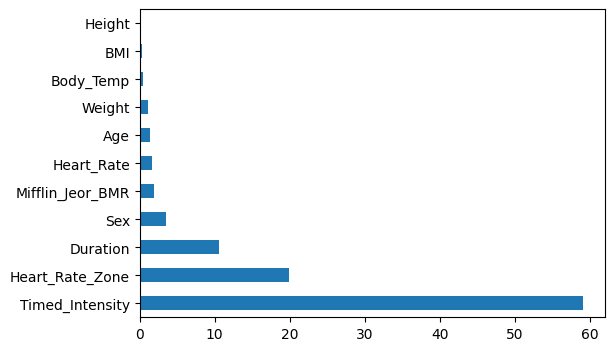

In [46]:
# CatBoost
fi_cb = pd.Series(cb_est.get_feature_importance(prettified=False),
                  index=feat_names_cb).sort_values(ascending=False)
fi_cb.head(15).plot.barh(figsize=(6,4))